In [2]:
from google.colab import files
import zipfile
import os

# Upload ZIP file manually
uploaded = files.upload()

# Extract the ZIP file
zip_path = "Preprocesseddata.zip"  # Change if your zip name is different
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract to /content/

# Check if files are extracted
print("✅ Files extracted. Folder contains:", os.listdir("/content/Preprocesseddata"))

Saving Preprocesseddata.zip to Preprocesseddata.zip
✅ Files extracted. Folder contains: ['key-14.png', 'jar-15.png', 'shoe-19.png', 'classic13.png', 'bat-14_frame1.png', 'camel-4_frame1.png', 'device7_8.png', 'shoe-1.png', 'classic12.png', 'Misk-10.png', 'shoe-3.png', 'fly-2.png', 'device3_14.png', 'Bone-5_frame1.png', 'shoe-7.png', 'fork-9.png', 'HCircle-10.png', 'pocket-11.png', 'cellular_phone-20_frame1.png', 'elephant11.png', 'Bone-9_frame1.png', 'device3_11.png', 'fly-14.png', 'jar-4.png', 'camel-16_frame1.png', 'camel-17_frame1.png', 'classic11.png', 'brick-18_frame1.png', 'device3_8.png', 'brick-08_frame1.png', 'brick-01_frame1.png', 'Glas-16.png', 'classic8.png', 'pocket-6.png', 'pocket-15.png', 'HCircle-15.png', 'key-1.png', 'HCircle-6.png', 'bat-19_frame1.png', 'fork-19.png', 'new_deer15.png', 'Misk-16.png', 'device7_13.png', 'key-13.png', 'new_deer17.png', 'device7_2.png', 'device3_20.png', 'device3_10.png', 'brick-05_frame1.png', 'Misk-6.png', 'device3_12.png', 'cellular_ph

In [12]:
import cv2
import numpy as np
import os
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler

# Paths
image_folder = "/content/Preprocesseddata"  # Change this to your dataset folder
raw_csv = "fourier_features_raw.csv"
normalized_csv = "fourier_features_normalized.csv"
filled_csv = "fourier_features_filled.csv"
query_image_path = "/content/bat-1_frame1.png"  # Update with actual query image path
num_coeffs = 20  # Number of Fourier coefficients to keep

# Function to compute Fourier Descriptor
def compute_fourier_descriptor(contour, num_coeffs=20):
    """
    Compute the Fourier Descriptor of a given contour.

    Parameters:
    - contour: Contour points obtained from cv2.findContours
    - num_coeffs: Number of Fourier coefficients to retain

    Returns:
    - descriptors: Array of Fourier coefficients
    """
    contour_complex = np.empty(contour.shape[0], dtype=complex)
    contour_complex.real = contour[:, 0, 0]
    contour_complex.imag = contour[:, 0, 1]

    fourier_result = fft(contour_complex)
    descriptors = np.abs(fourier_result[:num_coeffs])  # Take first N coefficients
    return descriptors

# Extract Fourier Features from dataset
feature_vectors = []
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        file_path = os.path.join(image_folder, filename)

        # Load image
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"❌ Error loading {filename}")
            continue

        # Thresholding to get binary image
        _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"❌ No contours detected in {filename}")
            continue

        # Select the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Compute Fourier Descriptor
        fourier_descriptor = compute_fourier_descriptor(largest_contour, num_coeffs)

        # Append filename and feature vector to list
        feature_vectors.append([filename] + list(fourier_descriptor))

# Convert to DataFrame
columns = ["Filename"] + [f"FD_{i}" for i in range(num_coeffs)]
df_raw = pd.DataFrame(feature_vectors, columns=columns)

# Save Raw Fourier Features
df_raw.to_csv(raw_csv, index=False)
print(f"✅ Fourier Descriptors (Raw) saved to {raw_csv}")

# Normalize features using Z-score normalization
scaler = StandardScaler()
df_normalized = df_raw.copy()
df_normalized.iloc[:, 1:] = scaler.fit_transform(df_raw.iloc[:, 1:])

# Save Normalized Fourier Features
df_normalized.to_csv(normalized_csv, index=False)
print(f"✅ Fourier Descriptors (Normalized) saved to {normalized_csv}")

# Handle missing values (replace NaN with column mean)
df_filled = df_normalized.copy()
df_filled.iloc[:, 1:] = df_filled.iloc[:, 1:].apply(lambda col: col.fillna(col.mean()), axis=0)

# Save Filled Fourier Features
df_filled.to_csv(filled_csv, index=False)
print(f"✅ Fourier Descriptors (Filled) saved to {filled_csv}")

# Load extracted features
df_features = pd.read_csv(filled_csv)  # Use the filled feature set for retrieval

# Function to find similar images
def get_similar_images(query_features, df, top_n=30):
    """
    Find the most similar images based on Euclidean distance.

    Parameters:
    - query_features: Feature vector of the query image
    - df: DataFrame containing precomputed Fourier features
    - top_n: Number of similar images to return

    Returns:
    - List of (filename, similarity score) sorted by similarity
    """
    similarities = []

    for _, row in df.iterrows():
        filename = row["Filename"]
        image_features = row.iloc[1:].values

        # Compute Euclidean distance
        distance = euclidean(query_features, image_features)
        similarities.append((filename, distance))

    similarities.sort(key=lambda x: x[1])  # Sort by similarity (lower is better)
    return similarities[:top_n]

# Load and process query image
query_image = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)

if query_image is None:
    print("❌ Error loading query image!")
else:
    # Threshold and find contours
    _, binary = cv2.threshold(query_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Compute Fourier Descriptor for query image
        query_features = compute_fourier_descriptor(contours[0], num_coeffs)

        # Normalize query features using the same scaler
        query_features = scaler.transform([query_features])[0]

        # Find similar images
        similar_images = get_similar_images(query_features, df_features, top_n=30)

        print("🔍 Top 30 similar images:")
        for img_name, score in similar_images:
            print(f"{img_name} → Similarity Score: {score:.4f}")
    else:
        print("❌ No object detected in the query image!")


✅ Fourier Descriptors (Raw) saved to fourier_features_raw.csv
✅ Fourier Descriptors (Normalized) saved to fourier_features_normalized.csv
✅ Fourier Descriptors (Filled) saved to fourier_features_filled.csv
🔍 Top 30 similar images:
bat-1_frame1.png → Similarity Score: 0.0000
bat-16_frame1.png → Similarity Score: 1.4827
bat-17_frame1.png → Similarity Score: 1.5269
bat-7_frame1.png → Similarity Score: 1.6624
fork-10.png → Similarity Score: 1.8594
bat-11_frame1.png → Similarity Score: 1.9526
HCircle-6.png → Similarity Score: 1.9687
bat-9_frame1.png → Similarity Score: 2.0238
bat-10_frame1.png → Similarity Score: 2.0318
fork-4.png → Similarity Score: 2.0388
pocket-20.png → Similarity Score: 2.0415
classic14.png → Similarity Score: 2.0462
classic15.png → Similarity Score: 2.0489
bat-15_frame1.png → Similarity Score: 2.0778
HCircle-7.png → Similarity Score: 2.0910
new_deer15.png → Similarity Score: 2.1209
pocket-11.png → Similarity Score: 2.1325
bat-12_frame1.png → Similarity Score: 2.1379
ke

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

# ✅ Load Fourier Descriptor features
df = pd.read_csv("fourier_features_filled.csv")  # Update filename if needed

# ✅ Extract Image Names and Features
image_names = df.iloc[:, 0].values  # First column has image names
dataset_features = df.iloc[:, 1:].values  # Remaining columns have features

# Example mapping of images to their relevant counterparts
relevant_images_map = {
        "bat-1_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ], # Add all relevant images for this query       "bat-1_frame1.png":
        "bat-2_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-3_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-4_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-5_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-6_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-7_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-8_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-9_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-10_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-11_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-12_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-13_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-14_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-15_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-16_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-17_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-18_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-19_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-20_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "Bone-1_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-2_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-3_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-4_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-5_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-6_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-7_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-8_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-9_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-10_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-11_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-12_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-13_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-14_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-15_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-16_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-17_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-18_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-19_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-20_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "brick-01_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-02_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-03_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-04_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-05_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-06_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-07_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-08_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-09_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-10_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-11_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-12_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-13_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-14_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-15_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-16_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-17_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-18_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-19_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-20_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "camel-1_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-2_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-3_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-4_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-5_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-6_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-7_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-8_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-9_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-10_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-11_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-12_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-13_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-14_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-15_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-16_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-17_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-18_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-19_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-20_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "cellular_phone-1_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-2_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-3_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-4_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-5_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-6_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-7_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-8_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-9_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-10_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-11_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-12_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-13_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-14_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-15_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-16_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-17_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-18_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-19_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-20_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "classic1.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic2.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic3.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic4.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic5.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic6.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic7.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic8.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic9.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic10.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic11.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic12.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic13.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic14.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic15.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic16.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic17.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic18.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic19.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic20.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "device3_1.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_2.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_3.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_4.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_5.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_6.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_7.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_8.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_9.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_10.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_11.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_12.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_13.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_14.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_15.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_16.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_17.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_18.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_19.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_20.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device7_1.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_2.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_3.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_4.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_5.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_6.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_7.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_8.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_9.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_10.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_11.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_12.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_13.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_14.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_15.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_16.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_17.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_18.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_19.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_20.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "elephant1.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant2.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant3.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant4.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant5.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant6.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant7_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant8_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant9_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant10.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant11.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant12.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant13_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant14.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant15.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant16.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant17.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant18.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant19.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant20.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "fly-1.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-2.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-3.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-4.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-5.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-6.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-7.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-8.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-9.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-10.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-11.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-12.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-13.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-14.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-15.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-16.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-17.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-18.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-19.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-20.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fork-1.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-2.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-3.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-4.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-5.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-6.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-7.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-8.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-9.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-10.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-11.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-12.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-13.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-14.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-15.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-16.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-17.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-18.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-19.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-20.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "Glas-1.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-2.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-3.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-4.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-5.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-6.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-7.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-8.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-9.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-10.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-11.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-12.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-13.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-14.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-15.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-16.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-17.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-18.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-19.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-20.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "HCircle-1.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-2.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-3.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-4.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-5.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-6.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-7.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-8.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-9.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-10.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-11.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-12.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-13.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-14.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-15.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-16.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-17.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-18.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-19.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-20.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "jar-1.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-2.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-3.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-4.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-5.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-6.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-7.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-8.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-9.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-10.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-11.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-12.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-13.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-14.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-15.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-16.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-17.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-18.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-19.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-20.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "key-1.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-2.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-3.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-4.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-5.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-6.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-7.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-8.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-9.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-10.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-11.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-12.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-13.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-14.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-15.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-16.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-17.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-18.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-19.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-20.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "Misk-1.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-2.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-3.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-4.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-5.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-6.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-7.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-8.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-9.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-10.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-11.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-12.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-13.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-14.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-15.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-16.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-17.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-18.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-19.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-20.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "new_deer1.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer2.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer3.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer4.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer5.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer6.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer7.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer8.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer9.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer10.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer11.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer12.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer13.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer14.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer15.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer16.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer17.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer18.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer19.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer20.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "pocket-1.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-2.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-3.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-4.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-5.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-6.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-7.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-8.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-9.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-10.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-11.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-12.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-13.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-14.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-15.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-16.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-17.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-18.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-19.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-20.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "shoe-1.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-2.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-3.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-4.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-5.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-6.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-7.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-8.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-9.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-10.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-11.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-12.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-13.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-14.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-15.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-16.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-17.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-18.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-19.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-20.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "teddy-1.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-2.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-3.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-4.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-5.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-6.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-7.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-8.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-9.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-10.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-11.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-12.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-13.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-14.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-15.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-16.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-17.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-18.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-19.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-20.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
    # Add other images and their relevant counterparts
}

# Function to get relevant images (with safe check)
def get_relevant_images(query_image_name):
    return relevant_images_map.get(query_image_name, [])

# Function to evaluate query image
def evaluate_query(query_image_name, query_features, top_n=30):
    y_scores = []  # Stores similarity scores (distances)
    y_true = []  # Stores relevance (1 = relevant, 0 = not relevant)

    for img_name, features in zip(image_names, dataset_features):
        distance = np.linalg.norm(query_features - features)  # Euclidean distance
        y_scores.append(distance)
        y_true.append(1 if img_name in get_relevant_images(query_image_name) else 0)

    # Convert to NumPy arrays and sort by similarity
    y_scores = np.array(y_scores)
    y_true = np.array(y_true)
    sorted_indices = np.argsort(y_scores)
    y_scores, y_true = y_scores[sorted_indices][:top_n], y_true[sorted_indices][:top_n]

    return y_true, y_scores

# Initialize lists to store precision, recall, and AUC values
all_precisions, all_recalls, all_aucs = [], [], []

# Loop through all images in the dataset
for query_index in range(len(image_names)):
    query_image_name = image_names[query_index]
    query_features = dataset_features[query_index]

    y_true, y_scores = evaluate_query(query_image_name, query_features)

    if np.any(y_true):  # Ensure relevant images exist
        precisions, recalls, _ = precision_recall_curve(y_true, -y_scores)  # Invert scores
        pr_auc = auc(recalls, precisions)

        all_precisions.append(np.mean(precisions))
        all_recalls.append(np.mean(recalls))
        all_aucs.append(pr_auc)

        print(f"Query {query_index+1}/{len(image_names)} → Precision: {all_precisions[-1]:.4f}, Recall: {all_recalls[-1]:.4f}, AUC: {pr_auc:.4f}")
    else:
        print(f"Query {query_index+1}/{len(image_names)} has no relevant images, skipping...")

# Compute Overall Average Precision and Recall
avg_precision = np.mean(all_precisions)
avg_recall = np.mean(all_recalls)

print(f"\n✅ Average Precision: {avg_precision:.4f}")
print(f"✅ Average Recall: {avg_recall:.4f}")


Query 1/400 → Precision: 0.7967, Recall: 0.6573, AUC: 0.8870
Query 2/400 → Precision: 0.4057, Recall: 0.6000, AUC: 0.6623
Query 3/400 → Precision: 0.6046, Recall: 0.6263, AUC: 0.6914
Query 4/400 → Precision: 0.6167, Recall: 0.7630, AUC: 0.8792
Query 5/400 → Precision: 0.7016, Recall: 0.7742, AUC: 0.9233
Query 6/400 → Precision: 0.2906, Recall: 0.5430, AUC: 0.3627
Query 7/400 → Precision: 0.5075, Recall: 0.5689, AUC: 0.5776
Query 8/400 → Precision: 0.5832, Recall: 0.6968, AUC: 0.7324
Query 9/400 → Precision: 0.2593, Recall: 0.6065, AUC: 0.3590
Query 10/400 → Precision: 0.7537, Recall: 0.6169, AUC: 0.8224
Query 11/400 → Precision: 0.5718, Recall: 0.4879, AUC: 0.5925
Query 12/400 → Precision: 0.3130, Recall: 0.9032, AUC: 0.8167
Query 13/400 → Precision: 0.3261, Recall: 0.6387, AUC: 0.5410
Query 14/400 → Precision: 0.9242, Recall: 0.6516, AUC: 0.9862
Query 15/400 → Precision: 0.1872, Recall: 0.6897, AUC: 0.5450
Query 16/400 → Precision: 0.2118, Recall: 0.4258, AUC: 0.3081
Query 17/400 → Pr

Query 1/400 → AUC: 0.8870
Query 2/400 → AUC: 0.6623
Query 3/400 → AUC: 0.6914
Query 4/400 → AUC: 0.8792
Query 5/400 → AUC: 0.9233
Query 6/400 → AUC: 0.3627
Query 7/400 → AUC: 0.5776
Query 8/400 → AUC: 0.7324
Query 9/400 → AUC: 0.3590
Query 10/400 → AUC: 0.8224
Query 11/400 → AUC: 0.5925
Query 12/400 → AUC: 0.8167
Query 13/400 → AUC: 0.5410
Query 14/400 → AUC: 0.9862
Query 15/400 → AUC: 0.5450
Query 16/400 → AUC: 0.3081
Query 17/400 → AUC: 0.6202
Query 18/400 → AUC: 0.9482
Query 19/400 → AUC: 0.5328
Query 20/400 → AUC: 0.5608
Query 21/400 → AUC: 0.9976
Query 22/400 → AUC: 1.0000
Query 23/400 → AUC: 0.5096
Query 24/400 → AUC: 0.6178
Query 25/400 → AUC: 0.4977
Query 26/400 → AUC: 0.5080
Query 27/400 → AUC: 0.7332
Query 28/400 → AUC: 0.8466
Query 29/400 → AUC: 0.5690
Query 30/400 → AUC: 0.7587
Query 31/400 → AUC: 0.8741
Query 32/400 → AUC: 0.6651
Query 33/400 → AUC: 1.0000
Query 34/400 → AUC: 0.9014
Query 35/400 → AUC: 0.9617
Query 36/400 → AUC: 0.6782
Query 37/400 → AUC: 0.7220
Query 38/4

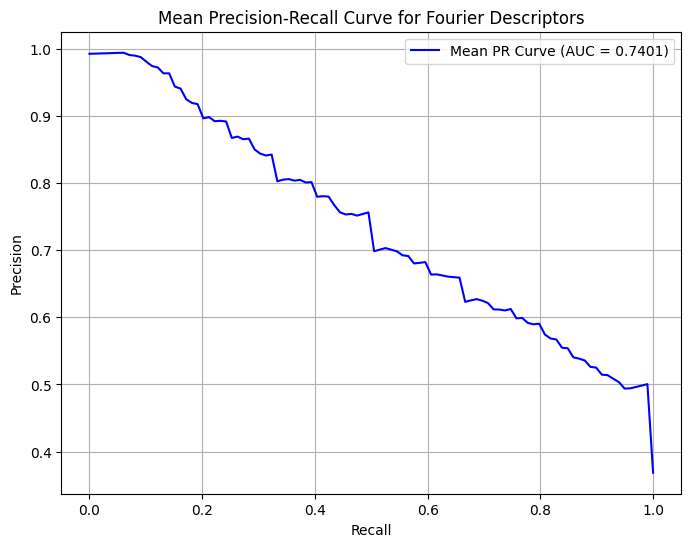

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# ✅ Load your dataset features (Make sure this file has image names and features)
df = pd.read_csv("fourier_features_filled.csv")  # Adjust filename if needed

# ✅ Extract Image Names and Features
image_names = df.iloc[:, 0].values  # First column has image names
dataset_features = df.iloc[:, 1:].values  # Remaining columns have features

# Function to get relevant images
def get_relevant_images(query_image_name):
    return relevant_images_map.get(query_image_name, [])

# Evaluate function to compute y_true and y_scores
def evaluate_query(query_image_name, query_features, top_n=30):
    y_scores = []  # Stores similarity scores (distances)
    y_true = []  # Stores relevance (1 = relevant, 0 = not relevant)

    for img_name, features in zip(image_names, dataset_features):
        distance = np.linalg.norm(query_features - features)  # Euclidean distance
        y_scores.append(distance)

        relevant_images = get_relevant_images(query_image_name)
        y_true.append(1 if img_name in relevant_images else 0)

    y_scores = np.array(y_scores)
    y_true = np.array(y_true)

    sorted_indices = np.argsort(y_scores)
    y_scores = y_scores[sorted_indices]
    y_true = y_true[sorted_indices]

    y_scores = y_scores[:top_n]
    y_true = y_true[:top_n]

    return y_true, y_scores

# Initialize lists to store precision, recall, and AUC values
all_aucs = []
recall_levels = np.linspace(0, 1, 100)
interp_precisions = np.zeros_like(recall_levels)

# Loop through all images in the dataset
for query_index in range(len(image_names)):
    query_image_name = image_names[query_index]
    query_features = dataset_features[query_index]

    y_true, y_scores = evaluate_query(query_image_name, query_features)

    if np.any(y_true):  # There are relevant images
        precisions, recalls, _ = precision_recall_curve(y_true, -y_scores)
        pr_auc = auc(recalls, precisions)
        all_aucs.append(pr_auc)
        interp_prec = np.interp(recall_levels, np.flip(recalls), np.flip(precisions))
        interp_precisions += interp_prec
        print(f"Query {query_index+1}/{len(image_names)} → AUC: {pr_auc:.4f}")

# Compute Mean Precision-Recall Curve
mean_precision = interp_precisions / len(all_aucs)
mean_auc = np.mean(all_aucs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_levels, mean_precision, label=f"Mean PR Curve (AUC = {mean_auc:.4f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Mean Precision-Recall Curve for Fourier Descriptors")
plt.legend()
plt.grid()
plt.show()